In [1]:
# 导入模型评估部分的代码
from utils import get_predictions, evaluate_model, print_evaluation_scores, plot_roc_curve, compute_metrics

# 1. 加载和构造数据集

In [2]:
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split

# 加载IMDB数据集
dataset = load_dataset("stanfordnlp/imdb")
# 去除 dataset['unsupervised']
dataset = DatasetDict({
    'train': dataset['train'],
    'test': dataset['test']
})


dataset

/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. 数据预处理

原始的数据包含一些html标签我们把他们去除掉

In [ ]:
import re

def delete_html_tags(example):
    example["text"] = re.sub(r"<[^>]+>", "", example["text"])
    return example

dataset = dataset.map(delete_html_tags)

dataset['train'][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it\'s 

在使用BERT进行文本分类时，通常保留原始文本的全部信息，包括停用词和标点符号。BERT模型已经在大规模的自然语言数据上进行预训练，并且对语言的上下文和细微差别有很强的理解能力。具体原因如下：

1.	上下文信息：停用词和标点符号在很多情况下对句子的上下文和语义有重要作用。去除这些词和符号可能会导致上下文信息的丢失，影响模型的理解。
2.	预训练一致性：BERT在预训练时并没有去除停用词和标点符号，所以在微调任务中保持与预训练时相同的数据格式可以更好地发挥模型的优势。
3.	BERT的分词机制：BERT使用的是WordPiece分词器，它能够有效处理标点符号和罕见词。手动去除标点符号和停用词可能会破坏这种分词效果。

因此，对于IMDB电影评论情感分类任务，通常直接使用原始文本，并让BERT模型来处理所有的词和符号。这通常会得到更好的分类效果。

所以不同于以往的方式我们在预处理阶段不删除符号和去除停用词

我们也不用自己进行分词

BERT使用的是WordPiece分词器，它能够将单词分解成更小的子词或字符，从而更好地处理生僻词、拼写错误和标点符号。因此，删除标点符号可能反而会影响模型的表现。

我们使用 `bert-base-uncased` 作为分类模型，这个模型将所有单词视为小写，这在我们的电影文本分类中是适用的，因为电影中通常没有使用专门的大写字母表示不同的概念，比如苹果：apple， 和苹果公司 Apple

In [7]:
from transformers import BertTokenizer

# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 定义预处理函数
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# 应用预处理函数
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['text'])

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [ ]:
train_test_split = tokenized_datasets["train"].train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]
test_dataset = tokenized_datasets["test"]

train_dataset, eval_dataset, test_dataset

In [12]:
import os

# 保存处理后的数据
path = './data/imdb_tokenized'
if not os.path.exists(path):
    os.makedirs(path)

train_dataset.save_to_disk(path + '/train')
eval_dataset.save_to_disk(path + '/eval')
test_dataset.save_to_disk(path + '/test')

Saving the dataset (1/1 shards): 100%|██████████| 25000/25000 [00:00<00:00, 63911.65 examples/s] 


In [2]:
# 定义一个函数，用于加载处理后的数据
def load_tokenized_dataset():
    from datasets import DatasetDict, load_metric, load_from_disk
    path = './data/imdb_tokenized'
    train_dataset = load_from_disk(path + '/train')
    eval_dataset = load_from_disk(path + '/eval')
    test_dataset = load_from_disk(path + '/test')
    return DatasetDict({
        'train': train_dataset,
        'eval': eval_dataset,
        'test': test_dataset
    })

datasets = load_tokenized_dataset()
datasets

/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
    eval: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
})

# 3. 定义模型

In [3]:
from transformers import BertTokenizer, DataCollatorWithPadding, BertForSequenceClassification, TrainingArguments, Trainer

# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# 加载预训练的BERT模型并添加分类层
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir= './bert_imdb',
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=3,
    warmup_ratio=0.2,
    logging_dir='./bert_imdb_train_logs',
    logging_strategy="epoch",
    save_strategy="epoch",
    report_to="tensorboard"
)

# 训练
trainer = Trainer(
    model,
    training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)

/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [5]:
trainer.train()

/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.323100,0.293847,0.888200,0.829681,0.981925,0.899406
2,0.142600,0.171125,0.939800,0.930215,0.953242,0.941587
3,0.058000,0.209701,0.942600,0.943093,0.944204,0.943648


/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=939, training_loss=0.17457880176548252, metrics={'train_runtime': 318.2275, 'train_samples_per_second': 188.544, 'train_steps_per_second': 2.951, 'total_flos': 1.57866633216e+16, 'train_loss': 0.17457880176548252, 'epoch': 3.0})

/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Bert Model Evaluation
Accuracy: 0.9406
Precision: 0.9373
Recall: 0.9445
F1 Score: 0.9409


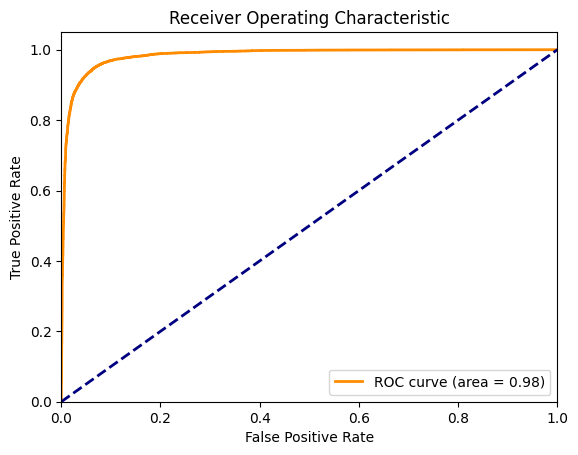

In [7]:
predicts = trainer.predict(datasets["test"])
pred, pred_score = get_predictions(predicts.predictions)
true = predicts.label_ids
print_evaluation_scores("Bert", true, pred)
plot_roc_curve("Bert", true, pred_score)